# MNIST Example Neutral Network in TensorFlow

To really dive into AI, we need to use one of the many frameworks. TensorFlow is a machine learning library from Google, and is the most well known and widely used to do this kind of work. It has several layers, allowing you to get arbitrarily deep into the weeds when it comes to coding machine learning code. However, for the purposes of this demo, we will stay at a fairly high level, using the packaged "Keras" library. Keras lets us look at neural networks in terms of layers of nodes, and is generally easy to work with for new users. It doesn't require a lot of the advanced math that some lower layers might need, instead just requiring a general understanding of when to apply certain techniques

In this demo, we will be using TensorFlow's Keras library to work on the MNIST dataset from before. While it is possible for non-AI code to do things like handwritten digit classification, AI is currently the state of the art. It also has the secondary benefit of being significantly easier in some cases to program. Some other approaches involve decision trees or support vector machines (https://en.wikipedia.org/wiki/Support-vector_machine)

This notebook will cover some of the data preparation required, training the AI, and evaluating the AI

To start with, we have our common imports

In [26]:
import os
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Since this is a new notebook, we will need to load the TensorFlow data again

In [27]:
train_df: pd.DataFrame = pd.read_csv('Resources/mnist_train.csv', header=None)
test_df: pd.DataFrame = pd.read_csv('Resources/mnist_test.csv', header=None)

We will split the dataset in the same way, separating the features from the labels

In [28]:
train_features: np.ndarray = train_df.loc[:, 1:].values

Next we need to unpack the features here into a 4d data structure. This is necessary because of the AI we will be using later in the notebook. The AI we use will have a convolutional layer. This layer is explained in more detail below, but it is very good at extracting information from images. However to use it we need to format the data in the way that it expects. The convolutional layer expects each input to be a 3d array, containing a set of pixels arranged by width and height, and then for each element in that matrix to be an array of 1 to 3 elements. In the case of our dataset, it's all greyscale, so we'll have a single element in each array but it could also be a set of three representing an \[R, G, B\] pixel value

In our case, we simply reshape it into 60,000 28x28x1 arrays

In [29]:
train_features = train_features.reshape((train_features.shape[0], 28, 28, 1))

Next we need to normalize the data. This is a very important step for two reasons: One it helps the model learn faster when the inputs are in the range \[0, 1\], and two it helps prevent the vanishing/exploding gradients problem in certain neural networks

The exact nature of the vanishing/exploding gradient problem is out of the scope of this demo, but you can find some information on the nature of the problem here: https://medium.com/learn-love-ai/the-curious-case-of-the-vanishing-exploding-gradient-bf58ec6822eb

To normalize the data, we simply divide it by the maximum value: 255 in our case, since we know the data is in the range \[0, 255\]

In [30]:
train_features = train_features / 255.0

Finally, we split out the labels

In [31]:
train_labels: np.ndarray = train_df[0].values

We do the same preprocessing for the test dataset

It's important to understand why we have a separate dataset for training and testing. Neural networks are designed to "learn" associations in data by looking at large sets of data. However, it can also learn some bad habits, for example if all of the digits were written by someone right-handed, it may learn habits associated with right handed digits and perform poorly when it comes to digits written with the left hand. This learning of peculiarities of a given sample of data is called "overfitting". It's a problem that arises when a training dataset doesn't fully accurately reflect reality. It is related to, but not the same as having a "biased" AI. There are several examples in the news lately of AI having biases for all sorts of reasons. One good way to help ensure good AI performance in terms of overfitting is to ensure that it can perform well on data that it hasn't seen before. To do this, we separate some of the data into a test dataset that is only used to evaluate the performance of the AI, and not to train it. This is only one tool, and bias and overfitting can occur in many ways, but it's always good practice to evaluate the AI on a test dataset to ensure it hasn't overfit to the training dataset.

You can read some more about bias in AI with a google search, but a good summary of some of the problems can be read at: https://www.technologyreview.com/s/612876/this-is-how-ai-bias-really-happensand-why-its-so-hard-to-fix/

In [32]:
test_features: np.ndarray = test_df.loc[:, 1:].values
test_features = test_features.reshape((test_features.shape[0], 28, 28, 1))
test_features = test_features / 255.0
test_labels: np.ndarray = test_df[0].values

Now we finally create our model

This model is a Sequential model, meaning that each layer sends its outputs to all inputs of the layer that follows it

We will add several layers into this model, along with some explanations about why these certain layers are good to use when solving certain problems, however there are many combinations that could possibly work. Building good intuition about when and how to use certain types of AI is going to be important in ensuring that your AIs perform well in the future

In [33]:
model: tf.keras.models.Sequential = tf.keras.models.Sequential()

### Conv2D
A layer performing convolution over a 2d input

Convolution is one of the most important techniques in modern AI, it's built on top of Fourier transformations, and is currently the state of the art when it comes to image analysis. In a basic convolution, one takes a small snapshot of the pixels, and examines how they blend together and applying a filter to strengthen or weaken the effect. This is done over the entire image, which allows things like edges to be strengthened or unimportant parts of the image to be blurred.

Deeper understanding of this layer requires quite a bit of math, but an excellent primer can be found at: https://timdettmers.com/2015/03/26/convolution-deep-learning/

Note that since this is the first layer, we also can specify input_shape, to help TensorFlow understand the shape of the input

In [34]:
model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), input_shape=(28, 28, 1)))

### MaxPooling2D
A layer pooling the max value in a 2d grid

This is a downsampling method, which allows a larger image to be downsampled by the max value in a given grid. In our previous layer, we modified the image to emphasize the important parts of the image (edges, spaces, etc). Now, to make the image easier to process, we take small grids (2x2 in this case), and take the max value from inside that grid and pass it on to the next layer. This helps get rid of less important data from the image, and make processing faster and usually more precise

In [35]:
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=2))

### Flatten
A layer flattening a multi-dimensional output into a single-dimensional output

This layer is pretty simple, flattening our 2d grid into a single array. This is useful to help the next layer process the data more efficiently. The Dense layer that follows works best with 1 or 2 dimensional inputs which keeps the underlying matrix multiplications simple. It's able to understand the same assocations, since the images are all flattened according to the same algorithm

In [36]:
model.add(tf.keras.layers.Flatten())

### Dense
A densely-connected classification layer

Dense layers are the basic classification layers, they receive inputs, and determine which parts of the input are important to classify data based on the outputs at the end. It does this by using something called an "activation function". The activation function determines from the inputs how large of an output the neuron will have. This simulates the activation of neurons in the brain, with certain levels of signal in a neuron affecting how great of an electrical impluse is sent out to connected neurons. In this case, these neurons take a weighted sum of the inputs, and produce an output. The weights are then updated as part of an optimization function which we'll cover a bit later with techniques like Gradient Descent and Backpropagation

To learn more about activation functions (a very key concept) and how they work, have a look at:
https://medium.com/the-theory-of-everything/understanding-activation-functions-in-neural-networks-9491262884e0

In [37]:
model.add(tf.keras.layers.Dense(units=64, activation=tf.nn.relu))

### Dropout
A layer that randomly removes certain dense nodes from training to prevent overfitting

Recall in the previous section where we mentioned overfitting. In order to prevent the AI from learning too many of the exact pecularities of the dataset there are several techniques broadly referred to as "regularization". This is one technique that is easy to apply to Keras layers. The dropout layer randomly removes a certain percentage of the previous layers from the network while training, to prevent them from becoming too specialized to the training dataset

You can read more about regularization techniques at:
https://towardsdatascience.com/regularization-in-machine-learning-76441ddcf99a

In [38]:
model.add(tf.keras.layers.Dropout(rate=0.2))

### Dense (but with softmax activation this time)
A classifier layer that outputs a max value

In this output layer, we want to classify the work done by all the previous layers. To do so, we take a layer that has nodes representing each class, and take the maximum activation value. That is to say that whichever set of neurons from the previous network provided the greatest confidence in its class becomes the output. In the case of a 0, we would see node 0 having the highest "activation" across all of the neurons. In cases where it's close, such as having a .59 and .60 activation we still take the max, knowing that there will likely be some misclassifications in edge cases like that

For some fun reading related to the misclassification based on close levels of activation, check out: https://medium.freecodecamp.org/chihuahua-or-muffin-my-search-for-the-best-computer-vision-api-cbda4d6b425d

This article covers a set of issues related to misclassifying dogs and bagels (and a google search of this problem can reveal more fun instances of similar issues)

In [39]:
model.add(tf.keras.layers.Dense(10, activation=tf.nn.softmax))

Finally, we compile our model, using a given optimizer and loss function

Our optimizer is the function or set of functions that determine how the model updates its weights as it trains. The loss function is how we calculate how accurate or inaccurate a result from training is. This loss function is minimized by using the optimization function.

The techniques used to train the AI are called (broadly) Gradient Descent and Backpropagation. Essentially, the optimizer updates the weights, performs a training iteration, and then updates the weights to be more accurate based on how much they contributed to the correct or incorrect classification during training. The way it calculates the degree that each neuron calculates how much it contributed to the answer is using a technique called "backpropagation". The specific functions used can heavily affect how well the AI performs at a given task. In this case, we use the "adam" optimizer, and the "sparse categorical crossentropy" function to calculate the loss

Finally, the metric we want to print out as we go through the training and testing is "accuracy". We defined this in the previous notebook as

### $ Accuracy = {Correct\_Predictions \over Total\_Predictions} $

Explanations of optimization, loss, and gradient descent, tend to be somewhat mathematical explanations and rather than dive in further in this notebook, you can read about exactly how these are calculated here:

https://towardsdatascience.com/gradient-descent-in-a-nutshell-eaf8c18212f0

https://medium.com/datathings/neural-networks-and-backpropagation-explained-in-a-simple-way-f540a3611f5e

https://skymind.ai/wiki/backpropagation

The adam optimizer is a variant of Stochastic Gradient Descent, and has some benefits, you can read about them at https://machinelearningmastery.com/adam-optimization-algorithm-for-deep-learning/

The loss functions can be read about at: https://blog.algorithmia.com/introduction-to-loss-functions/

In [40]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

We can see a summary of the layers, and how they are connected with `model.summary()`

In [41]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 5408)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                346176    
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 10)                650       
Total params: 347,146
Trainable params: 347,146
Non-trainable params: 0
________________________________________________

### Training

Finally we train the model with the features and labels we formatted earlier. Depending on the machine, this may happen very quickly or very slowly. Training a model in some more advanced cases could even take days, hence why the advancements in GPU performance have been so crucial in bringing AI into viability for solving many problems that were once thought intractable

In [42]:
model.fit(train_features, train_labels, epochs=3)

Epoch 1/3
1875/1875 [==============================] - 6s 3ms/step - loss: 0.4242 - accuracy: 0.8691
Epoch 2/3
1875/1875 [==============================] - 6s 3ms/step - loss: 0.1115 - accuracy: 0.9657
Epoch 3/3
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0763 - accuracy: 0.9751


### Testing

Now that we have trained the model, we need to ensure that it will generalize to data that it hasn't seen before. In this case, we want the accuracy and loss to be fairly close to the values we saw at the end of the training. If they're not, that indicates that our model is probably overfitted to the training data to some extent, and won't perform well on data it hasn't seen before.

Note that no AI is perfect, and this is a departure from traditional computer science where results tend to be either right or wrong, an AI can make mistakes. This tradeoff is important to understand, and is a reason why AI is not suitable for every problem. However, AI becoming more practical has opened up the ability to solve a vast set of problems that were once considered nearly impossible

In [43]:
model.evaluate(test_features, test_labels)

313/313 [==============================] - 0s 1ms/step - loss: 0.0625 - accuracy: 0.9796


[0.06247013434767723, 0.9796000123023987]

### Saving

Finally, we want to save our model out, since we'll be reusing it in a later notebook

There are many ways to save the model, but the most common are:
* HDF5 format, a which saves the model as a single file with the configuration of the layers and weights included
* JSON format, which saves just the configuration of the layers, it requires the weights to be saved separately
* SavedModel format, a TensorFlow-specific layout involving a few directories. This format is required by the TensorFlow Serving server which allows you to easily serve the model to other systems

In [44]:
# If you want to save the model in its current state in HDF5 format, you would use the following
model.save('mnist-model/mnist-model.h5', overwrite=True, include_optimizer=True)

# We'll explore in the next section how to serve this model

### Showing some examples

We can also show some examples from the test dataset along with their predictions

You can re-run this cell to select a different example

Features:
Predicted label: 2


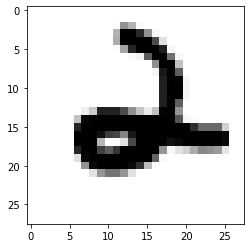

In [57]:
# Select a random example
selected_element = np.random.randint(0, 9999)

features = test_features[selected_element].reshape((28,28))
label = test_labels[selected_element]

print("Features:")
plt.imshow(features, cmap="Greys")

#print("Actual label: " + str(label))

print("Predicted label: " + str(model.predict(features.reshape((1,28,28,1)))[0].argmax()))

{'prediction': '4'}

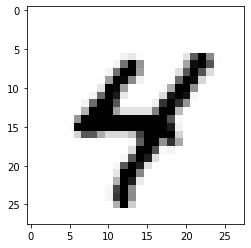

In [68]:
#test predict function for prediction.py file

import tensorflow as tf
import keras
import numpy as np
import base64

#load mnist-model.h5
model = keras.models.load_model('mnist-model/mnist-model.h5')

#user does not pass integer, random integer is selected automatically
def predict():
    # Select a random example
    selected_element        = np.random.randint(0, 9999)
    
    features                = test_features[selected_element].reshape((28,28))
    label                   = test_labels[selected_element]
    
    #print image of selected element
    plt.imshow(features, cmap="Greys")  
    
    #use model to predict the actual numeric equivalent of mnist image
    single_predicted_label  = str(model.predict(features.reshape((1,28,28,1)))[0].argmax())

    return {'prediction': single_predicted_label}

predict()
